In [ ]:
!ls


sample_data


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import imageio
import time
from IPython.display import HTML


from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs,make_moons

In [ ]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [ ]:
np.random.seed(0)

In [ ]:
data,labels=make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0 )

In [ ]:
data,labels=make_moons(n_samples=1000, noise=0.15, random_state=0 )

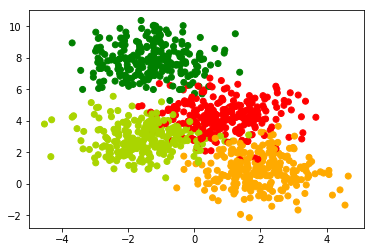

In [ ]:
plt.scatter(data[:,0],data[:,1],c=labels,cmap=my_cmap)
plt.show()

In [ ]:
labels_orig = labels

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [ ]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

**vectorized**


In [ ]:
class FFSN_MultiClass:
  
  def __init__(self, n_inputs, n_outputs, hidden_sizes=[3]):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny] 

    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      
  def sigmoid(self, X):
    return 1.0/(1.0 + np.exp(-X))
  
  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps)

  
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()
 
  def grad_sigmoid(self, X):
    return X*(1-X) 
  
  def cross_entropy(self,label,pred):
    yl=np.multiply(pred,label)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl
  
    
 
  def grad(self, X, Y):
    self.forward_pass(X)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - Y)
    
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = np.sum(self.dA[k],axis=0).reshape(1, -1)
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1])) 
      
    
  def forward_pass(self, X):
    self.A = {}
    self.H = {}
    self.H[0] = X
    
    for i in range(self.nh):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.H[self.nh], self.W[self.nh+1]) + self.B[self.nh+1]
    self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
    return self.H[self.nh+1]
    
  def fit(self, X, Y, epochs=100, initialize='True',algo="MiniBatch", learning_rate=0.01, display_loss=False,mini_batch_size=256):
      
    if display_loss:
      loss = {}
      
    if initialize:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
        
    for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dW = {}
      dB = {}
      m = X.shape[1]
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
     
      if algo=="GD":
        self.grad(X,Y) 
#         for i in range(self.nh+1):
#           dW[i+1] += self.dW[i+1]
#           dB[i+1] += self.dB[i+1]
        for i in range(self.nh+1):
          self.W[i+1] -= learning_rate * (self.dW[i+1]/m)
          self.B[i+1] -= learning_rate * (self.dB[i+1]/m)
        
      elif algo=="MiniBatch":
        for k in range(0,m,mini_batch_size):
          self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
#           for i in range(self.nh+1):
#             dW[i+1] += self.dW[i+1]
#             dB[i+1] += self.dB[i+1]
          for i in range(self.nh+1):
            self.W[i+1] -= learning_rate * (self.dW[i+1]/mini_batch_size)
            self.B[i+1] -= learning_rate * (self.dB[i+1]/mini_batch_size)
      
      if display_loss:
        Y_pred = self.predict(X) 
        loss[epoch] = self.cross_entropy(Y, Y_pred)
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      plt.ylabel('CE')
      plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


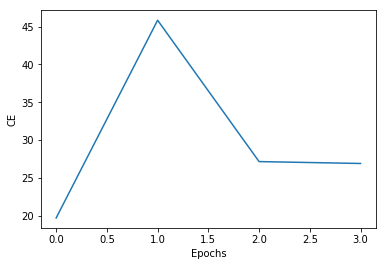

Training accuracy 0.5
Validation accuracy 0.5
CPU times: user 38.4 s, sys: 408 ms, total: 38.8 s
Wall time: 38.6 s


In [ ]:
%%time
ffsn_multi = FFSN_MultiClass(2,2,[2])
ffsn_multi.fit(X_train,y_OH_train,epochs=100000,algo="GD",learning_rate=0.5,display_loss=True)
print_accuracy()

In [ ]:
class FFSN_MultiClass:
  
  def __init__(self, n_inputs, n_outputs,activation_function="sigmoid", hidden_sizes=[3],leaky_slope=0.01, init_function="random"):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny] 
    self.activation_function=activation_function
    self.leaky_slope=leaky_slope
    self.W = {}
    self.B = {}
    self.v_w={}
    self.v_b={}
    self.prev_v_w={}
    self.prev_v_b={}
    if init_function=="random":
        for i in range(self.nh+1):
          self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
          self.B[i+1] = np.zeros((1, self.sizes[i+1]))
          self.v_w[i+1] = np.zeros((1, self.sizes[i+1]))
          self.v_b[i+1] = np.zeros((1, self.sizes[i+1]))
          self.prev_v_w[i+1] = np.zeros((1, self.sizes[i+1]))
          self.prev_v_b[i+1] = np.zeros((1, self.sizes[i+1]))
    elif init_function=="xavier":
        for i in range(self.nh+1):
          self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])*np.sqrt(1/self.sizes[i])
          self.B[i+1] = np.zeros((1, self.sizes[i+1]))
          self.v_w[i+1] = np.zeros((1, self.sizes[i+1]))
          self.v_b[i+1] = np.zeros((1, self.sizes[i+1]))
          self.prev_v_w[i+1] = np.zeros((1, self.sizes[i+1]))
          self.prev_v_b[i+1] = np.zeros((1, self.sizes[i+1]))
    elif init_function=="he":
        for i in range(self.nh+1):
          self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])*np.sqrt(2/self.sizes[i])
          self.B[i+1] = np.zeros((1, self.sizes[i+1]))
          self.v_w[i+1] = np.zeros((1, self.sizes[i+1]))
          self.v_b[i+1] = np.zeros((1, self.sizes[i+1]))
          self.prev_v_w[i+1] = np.zeros((1, self.sizes[i+1]))
          self.prev_v_b[i+1] = np.zeros((1, self.sizes[i+1]))
        
        
      
  def forward_function(self, x):
    if self.activation_function=="sigmoid":
        return 1.0/(1.0 + np.exp(-x))
    elif self.activation_function=="tanh":
        return np.tanh(x)
    elif self.activation_function=="ReLu":
        return np.maximum(0,x)
    elif self.activation_function=="LeakyReLu":
        return np.maximum(self.leaky_slope*x,x)
  
  def softmax(self, x):
    exps = np.exp(x)
    return exps / np.sum(exps)

  def forward_pass(self, x, W= None, B= None):
    if W and B==None:
      W=self.W
      B=self.B
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.forward_function(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.H[self.nh], self.W[self.nh+1]) + self.B[self.nh+1]
    self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
    return self.H[self.nh+1]
  
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()
 
  def grad(self, x):
    if self.activation_function=="sigmoid":
        return x*(1-x)
    elif self.activation_function=="tanh":
        return (1-np.square(x))
    elif self.activation_function=="ReLu":
        if x>0:
            d=1
        else:
            d=0
        return d
    elif self.activation_function=="LeakyReLu":
        if x>0:
            d=1
        else:
            d=self.leaky_relu
        return d
    
  
  def cross_entropy(self,label,pred):
    yl=np.multiply(pred,label)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl
 
  def grad(self, x, y,W= None, B= None):
    if W and B==None:
      W=self.W
      B=self.B
    self.forward_pass(x,W,B)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad(self.H[k-1])) 
    
  def fit(self, X, Y, epochs=100, initialize='True', learning_rate=0.01, display_loss=False, algo="GD", gamma=0.9, mini_batch_size=100):
    m = X.shape[1]  
    if display_loss:
      loss = {}
      
    if initialize:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
        
    for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      
      
      if algo=="GD":
     
        for x, y in zip(X, Y):
          self.grad(x, y)
          for i in range(self.nh+1):
            dW[i+1] += self.dW[i+1]
            dB[i+1] += self.dB[i+1]
                  
        
        for i in range(self.nh+1):
          self.W[i+1] -= learning_rate * (dW[i+1]/m)
          self.B[i+1] -= learning_rate * (dB[i+1]/m)
      
      elif algo=="MiniBatch":
        for k in range(0,m,mini_batch_size):
          for x, y in zip(X[k:k+mini_batch_size], Y[k:k+mini_batch_size]):
            self.grad(x, y)
            for i in range(self.nh+1):
              dW[i+1] += self.dW[i+1]
              dB[i+1] += self.dB[i+1]
          for i in range(self.nh+1):
            self.W[i+1] -= learning_rate * (dW[i+1]/mini_batch_size)
            self.B[i+1] -= learning_rate * (dB[i+1]/mini_batch_size)
      
      elif algo=="Momentum":
        for x, y in zip(X, Y):
          self.grad(x, y)
          for i in range(self.nh+1):
            dW[i+1] += self.dW[i+1]
            dB[i+1] += self.dB[i+1]
            self.v_w[i+1]=self.v_w[i+1]*gamma+(learning_rate*dW[i+1]/m)
            self.v_b[i+1]=self.v_b[i+1]*gamma+(learning_rate*dB[i+1]/m)
            
        for i in range(self.nh+1):
          
          self.W[i+1]-=self.v_w[i+1]
          self.B[i+1]-=self.v_b[i+1]
          
          
      elif algo=="NAG":
        temp_W={}
        temp_B={}
        for i in range(self.nh+1):
          self.v_w[i+1]=gamma*self.prev_v_w[i+1]
          self.v_b[i+1]=gamma*self.prev_v_b[i+1]
          temp_W[i+1]=self.W[i+1]-self.v_w[i+1]
          temp_B[i+1]=self.B[i+1]-self.v_b[i+1]
        for x,y in zip(X,Y):
          self.grad(x,y,temp_W,temp_B)
          for i in range(self.nh+1):
            dW[i+1] += self.dW[i+1]
            dB[i+1] += self.dB[i+1]
        for i in range(self.nh+1):
          
          self.v_w[i+1]=self.v_w[i+1]*gamma+(learning_rate*dW[i+1]/m)
          self.v_b[i+1]=self.v_b[i+1]*gamma+(learning_rate*dB[i+1]/m)
          self.W[i+1]-=learning_rate*self.v_w[i+1]
          self.B[i+1]-=learning_rate*self.v_b[i+1]
          
          
            
            
        
                  
 
         
        
      
      
      
      
      
      
      
      
      
      
      
      
      if display_loss:
        Y_pred = self.predict(X) 
        loss[epoch] = self.cross_entropy(Y, Y_pred)
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      plt.ylabel('CE')
      plt.show()

In [ ]:
def print_accuracy():    
    Y_pred_train = ffsn_multi.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = ffsn_multi.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))
    
    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

In [ ]:
# ffsn_multi = FFSN_MultiClass(2,4,[2,3])
# ffsn_multi.fit(X_train,y_OH_train,epochs=2000,learning_rate=.005,display_loss=True)

In [ ]:
# Y_pred_train = ffsn_multi.predict(X_train)
# Y_pred_train = np.argmax(Y_pred_train,1)

# Y_pred_val = ffsn_multi.predict(X_val)
# Y_pred_val = np.argmax(Y_pred_val,1)

# accuracy_train = accuracy_score(Y_pred_train, Y_train)
# accuracy_val = accuracy_score(Y_pred_val, Y_val)

# print("Training accuracy", round(accuracy_train, 2))
# print("Validation accuracy", round(accuracy_val, 2))

In [ ]:
%%time
ffsn_multi = FFSN_MultiClass(2,2,[2],init_function="xavier")
ffsn_multi.fit(X_train, y_OH_train, epochs=1000, learning_rate=0.5, algo="GD", mini_batch_size=128, display_loss=True)
print_accuracy()

ValueError: ignored

In [ ]:
 %%time
 ffsn_multi = FFSN_MultiClass(2,4,[2])
 ffsn_multi.fit(X_train, y_OH_train, epochs=4000, learning_rate=0.1, algo="Momentum", display_loss=True, gamma=0.9)
 print_accuracy()


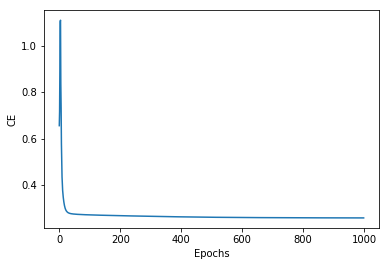

Training accuracy 0.868
Validation accuracy 0.868
CPU times: user 54.7 s, sys: 609 ms, total: 55.3 s
Wall time: 55.4 s


In [ ]:
%%time
ffsn_multi = FFSN_MultiClass(2,2,[2])
ffsn_multi.fit(X_train, y_OH_train, epochs=1000, learning_rate=0.1, algo="NAG", display_loss=True,gamma=0.9)
print_accuracy()